<a href="https://colab.research.google.com/github/alexisakov/FederalRevenues/blob/master/HyperbolaParabola.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 	(Very) Technical Brief Geometry of the Fiscal Rule: Hyperbola or Parabola?



In this online appendix we will recreate a key chart from the technical brief: the ratio of MinFin's FX purchases to oil export revenues.

All calculations are done for illustrative purposes - the schematically replicate Russia's oil taxation system for an economy that produces 1 ton of oil and export 0.5 tons. 

## Preliminaries

Import libs.

In [30]:
#This uses the same mechanisms. 
%matplotlib inline

import seaborn as sns
sns.set(color_codes=True)
import pandas as pd

## Oil and gas export revenue

Relationship between oil and gas exports and oil price x output is historically stable - so we can write an estimated export revenue in RUB function as follows:

In [31]:
m = 0.00649369 # constant
exportrevenue = lambda extractionVolume, exportRatio, oilprice, USDRUB : (exportRatio/0.75)*m*extractionVolume*oilprice*USDRUB

*    extractionVolume - oil output (inc. condensate), mn ton
*    exportRatio - % share of oil output exported as crude + petroleum products - 75% is a crudle proxy to historical norm
*    oilprice - oil price, USD/bbl

Sanity check: In 2020 oil output is 512 mn ton, average oil price is 42.7 - total oil and gas exports (ex. LNG) should total USD 143bn (USDRUB @ 71.9):


In [32]:
exportrevenue(512,0.75,42.7,71.9)/71.9 # devide by USDRUB to get bn USD

141.96764825600002

Good enough.

## Schematic oil taxation

Set various constants and parameters:

In [33]:
baseoilprice = 40; # baseline oil price
oilpj = 60.3; # oil price behind budget parameters // expected oil price  
estUSDRUB = 73; # expected USDRUB
ton2barrel = 7.33 # ton to barrel conversion factor

This is toy example - does not capture true complexity of the tax scheme and loosely approximates 2020 parameters - which are themselves drifting.

### MET

Mineral extraction tax:

In [82]:
METBaseRate = 919; 
METKk = 428;
METKkorr = 0.33;

In [83]:
Кц = lambda oilprice, USDRUB :(oilprice - 15) * USDRUB/261

In [84]:
METPart1 = lambda oilprice, USDRUB: METBaseRate* Кц(oilprice, USDRUB)

In [85]:
def ЭП(oilprice):
  if oilprice < 109.5/ton2barrel:
    return 0,
  elif oilprice < 146/ton2barrel:
    return 0.35*(oilprice*ton2barrel - 109.5)
  elif oilprice < 182.5/ton2barrel:
    return 12.78 + 0.45*(oilprice*ton2barrel - 146)
  else:
    return 29.2 + 0.3*(oilprice*ton2barrel - 182.3)

In [86]:
Кман = lambda oilprice, USDRUB : ЭП(oilprice)*USDRUB*METKkorr

In [87]:
Дм = lambda oilprice, USDRUB : METKk - Кман(oilprice, USDRUB)

In [88]:
METTheory = lambda extractionVolume, oilprice, USDRUB: extractionVolume*(METPart1(oilprice, USDRUB) - Дм(oilprice, USDRUB))

Effective MET collection:

In [89]:
METCollectionRate = 0.90;
MET = lambda extractionVolume, oilprice, USDRUB : METCollectionRate*METTheory(extractionVolume, oilprice, USDRUB) / 1000

Sanity check: MET corresponding to 2020 oil output (MET is paid with 1 month shift, so this total is for Feb'20-Jan'21) - should be RUB 3766bn:

In [90]:
MET(512,42.7,71.9)

3782.142361340647

Good enough.

### Export duty

Export duty parameters:

In [91]:
EDKkorr = 0.67;
EDuty = 0.3;

In [92]:
edRate = lambda oilprice, USDRUB : (29.2 + EDuty*(oilprice*ton2barrel - 182.5))*USDRUB*EDKkorr

In [93]:
EDTheory = lambda extractionVolume, exportRatio, oilprice, USDRUB : extractionVolume*exportRatio*edRate(oilprice, USDRUB)

In [94]:
EDCollectionRate = 0.80;
ED = lambda extractionVolume, exportRatio, oilprice, USDRUB : EDCollectionRate*EDTheory(extractionVolume, exportRatio, oilprice, USDRUB) / 1000

Sanity check, should be RUB 1148bn

In [95]:
ED(512, 0.75, 42.7,71.9)

1011.4543051468801

Good enough.

### Gather taxes

In [96]:
oilgasrevenue = lambda extractionVolume, exportRatio, oilprice, USDRUB : MET(extractionVolume, oilprice, USDRUB) + ED(extractionVolume,exportRatio,oilprice, USDRUB)

### Oil taxation under Fiscal rule: Base and Excess Revenues

Total oil budget revenue is a total of MET and ED:

Now we can define excess revenu (=FX purchases) as follows:

In [97]:
excessrevenue = lambda extractionVolume, exportRatio, oilprice, USDRUB: oilgasrevenue(extractionVolume, exportRatio, oilprice, USDRUB) - oilgasrevenue(
    extractionVolume, exportRatio, baseoilprice, USDRUB)

## Chart - Relative export revenue neutralization

We attempt to calculate the ration of

*   export revenue in USD
*   to excess oil budget revenue = MinFin's FX purchases

for an economy that 

*   produces 1 ton of oil, 
*   export 0.5 ton of oil 
*   and has a RUB/oil sensitivity of 0.1.

In [98]:
x = list(range(20,200,1))

In [99]:
druboil = 0.07

In [106]:
y = [excessrevenue(1.0, 0.75, oil, 73*(1 - druboil*(oil/oilpj - 1)))/exportrevenue(1.0, 0.75, oil, 73*(1 - druboil*(oil/oilpj - 1))) for oil in x]

In [107]:
df = pd.DataFrame(list(zip(x, y)),columns=['oil price','FX purchases, % export revenue'])

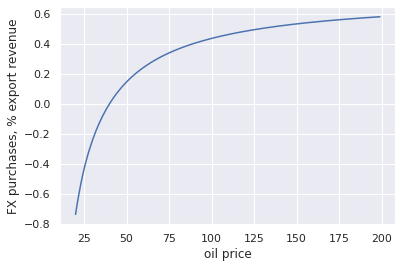

In [108]:
sns.lineplot(x = 'oil price', y = 'FX purchases, % export revenue', data=df)

So everything checks out - MinFin's FX purchases approach 100% of oil export revenue as oil price approaches USD150/bbl.

In [113]:
x2er = [excessrevenue(1.0, 0.75, oil, 73*(1 - druboil*(oil/oilpj - 1))) / exportrevenue(1.0, 0.75, oil-40, 73*(1 - druboil*(oil/oilpj - 1))) if exportrevenue(1.0, 0.75, oil-40, 73*(1 - druboil*(oil/oilpj - 1))) else 0. for oil in x]

In [114]:
df = pd.DataFrame(list(zip(x, x2er)),columns=['oil price','FX purchases, % export excess revenue'])

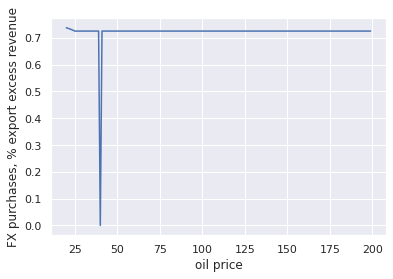

In [115]:
sns.lineplot(x = 'oil price', y = 'FX purchases, % export excess revenue', data=df)

In [ ]:
25851.613984674317/36650.0

0.7053646380538695

In [118]:
(oilgasrevenue(500,0.75,60,73)-oilgasrevenue(500,0.75,50,73))/73

23.530332586206896

In [119]:
(exportrevenue(500, 0.75, 60, 73)-exportrevenue(500, 0.75, 50, 73))/73

32.468449999999976